# Solar Panel Dust Detection with PyTorch
The accumulation of dust on the surface of solar panels reduces the efficiency of the solar modules and hence the amount of produced energy. In countries where output power loss due to dust accumulation is considered among the highest rate; monitoring and cleaning solar panels is a crucial task, hence developing an optimal procedure to monitor and clean these panels is very important in order to increase modules efficiency, reduce maintenance cost and reducing the use of resources.

## 1. Libraries and GPU

In [1]:
!nvidia-smi

Tue Feb 21 23:46:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torchmetrics

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pylab import rcParams
import os

In [3]:
from tqdm.auto import tqdm
from glob import glob
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from PIL import Image
import torchmetrics
from timeit import default_timer as timer
import gc

In [4]:
%matplotlib inline
rcParams['figure.figsize'] = 10, 6
warnings.filterwarnings('ignore')

In [5]:
from google.colab import drive
drive.mount("/content/drive")
path = '/content/drive/MyDrive/Datasets/Solar_Dust/Detect_solar_dust/' 

Mounted at /content/drive


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Creating Datasets

The dataset used in this project comes from Kaggle: https://www.kaggle.com/datasets/hemanthsai7/solar-panel-dust-detection

There are two classes for this images: Clean & Dusty. Some images were removed from the original dataset due to errors in the classification of this images in the folders.

In [37]:
trans = transforms.Compose([transforms.RandomResizedCrop(512),
                            transforms.ToTensor(),
                            transforms.RandomHorizontalFlip()])

In [38]:
dataset = datasets.ImageFolder(path, transform=trans)
class_names = dataset.classes
class_names

['Clean', 'Dusty']

Split dataset into training and testing sets

In [39]:
train_set_size = int(len(dataset) * 0.8)
test_set_size = len(dataset) - train_set_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_set_size, test_set_size])

In [40]:
def collate_fn(batch):
    images, labels = tuple(zip(*batch))
    images = torch.stack(images, dim=0)
    labels = torch.as_tensor(labels)
    return images, labels

In [41]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

## Display Images

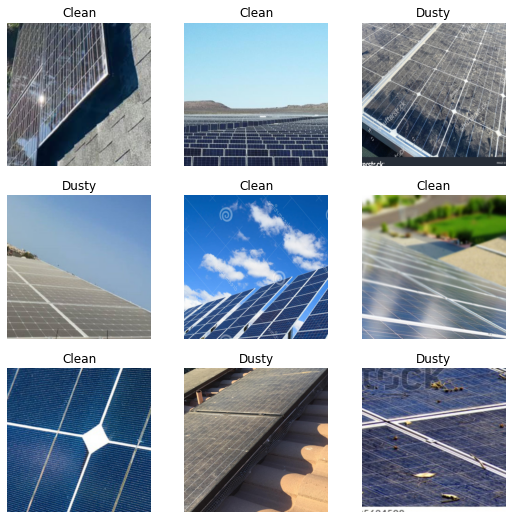

In [43]:
# Plot images
torch.manual_seed(27)
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(dataset), size=[1]).item()
    img, label = dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0)) 
    plt.title(class_names[label])
    plt.axis(False);

## Model

In [19]:
from torch.nn.modules.conv import Conv2d
class SolarClassification(nn.Module):
    def __init__(self, input_shape, out_shape, kernel_conv=3, drop_out=0.3):
        super().__init__()
        # Layers
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=64, kernel_size=kernel_conv, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=kernel_conv, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(128)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=kernel_conv, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=kernel_conv, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(drop_out),
            nn.BatchNorm1d(128*128*128),
            nn.Linear(in_features=128*128*128,out_features=out_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        #print(x.shape)
        x = self.block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        return x

# Training

The accuracy and f1-score were used to evaluate the model. At the end of this notebook a confusion matrix is display.

In [21]:
accuracy = torchmetrics.Accuracy(task='binary').to(device)
f1 = torchmetrics.F1Score(task='binary').to(device)
cm = torchmetrics.ConfusionMatrix(task='binary', num_classes=2)

In [22]:
def train(model, device, train_dataloader, optimizer, loss_fn):
    model.train()
    train_loss, train_acc = 0, 0
    for batch_idx, (X, y) in enumerate(train_dataloader):
        X_train, y_train = X.to(device), y.to(device)

        # Forward pass
        y_logits = model(X_train).squeeze()       
        y_pred = torch.round(torch.sigmoid(y_logits))

        optimizer.zero_grad()

        loss = loss_fn(y_logits, y_train.float())
        train_loss += loss
        acc = accuracy(y_pred, y_train)    
        train_acc += acc

        # Backward & Optimizer Step
        loss.backward()
        optimizer.step()

        del X_train
        del y_train
        gc.collect()
        torch.cuda.empty_cache()
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    return train_loss, train_acc

In [23]:
def test(model, device, test_dataloader, loss_fn):
    model.eval()
    test_loss, test_acc, test_f1 = 0, 0, 0
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))
           
            test_loss += loss_fn(test_logits, y_test.float())
            test_f1 += f1(test_pred, y_test)
            test_acc += accuracy(test_pred, y_test)

            del X_test
            del y_test
            gc.collect()
            torch.cuda.empty_cache()

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        test_f1 /= len(test_dataloader)
    return test_loss, test_acc, test_f1

## Training experiment (hyperparameter tuning)
Differents hiperparameters were tested in order to find the best choice that fits the model.

In [24]:
df_params = pd.DataFrame(columns=['learning_rate', 'n_neurons', 'kernel_size', 'dropout', 'train_loss', 'train_acc', 'test_loss', 'test_acc', 'test_f1'])
rows_ls = []

In [23]:
torch.manual_seed(27)

learning_rates = [0.1, 0.01, 0.001]
kernel_conv = [3]
dropouts = [0.2, 0.3]
hidden_neurons = [64, 128]
num_epochs = 20

for lr in learning_rates:
    for kernel in kernel_conv:
        for drop in dropouts:
            for hidden_n in hidden_neurons:
                device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
                print(f"Learning rate: {lr}, Hidden Neurons: {int(hidden_n/2)}, Kernel Conv: {kernel}, Drop out: {drop}, Device: {device}")
                model = SolarClassification(input_shape=3, hidden=hidden_n, out_shape=1, kernel_conv=kernel, drop_out=drop).to(device)
                loss_fn = nn.BCEWithLogitsLoss()
                optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

                for epoch in tqdm(range(num_epochs)):
                    train_loss, train_acc = train(model, device, train_dataloader, optimizer, loss_fn)
                    test_loss, test_acc, test_f1 = test(model, device, test_dataloader, loss_fn)
                    print(f"\n Epoch: {epoch+1}, Train loss: {train_loss:.5f} Train acc: {train_acc:.2f}%| Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%, F1-score: {test_f1:.2f}\n")
                    
                    row = {'train_loss': train_loss.item(), 'train_acc': train_acc.item(), 'test_loss': test_loss.item(), 'test_acc': test_acc.item(),
                          'test_f1': test_f1.item(), 'learning_rate': lr, 'n_neurons': hidden_n/2, 'kernel_size': kernel, 'dropout': drop}
                    rows_ls.append(row)
                    df_params.append(row, ignore_index=True)
                pd.DataFrame(rows_ls).to_csv(path+'train_experiment.csv', index=False)

Learning rate: 0.001, Hidden Neurons: 64, Kernel Conv: 3, Drop out: 0.2, Device: cuda


  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch: 1, Train loss: 6.27973 Train acc: 0.62%| Test loss: 14.12302, Test acc: 0.54%, F1-score: 0.53


 Epoch: 2, Train loss: 3.83446 Train acc: 0.64%| Test loss: 59.59230, Test acc: 0.47%, F1-score: 0.58


 Epoch: 3, Train loss: 2.55925 Train acc: 0.65%| Test loss: 2.52515, Test acc: 0.69%, F1-score: 0.66


 Epoch: 4, Train loss: 2.14024 Train acc: 0.67%| Test loss: 1.79633, Test acc: 0.64%, F1-score: 0.55


 Epoch: 5, Train loss: 1.80299 Train acc: 0.69%| Test loss: 2.08871, Test acc: 0.68%, F1-score: 0.66


 Epoch: 6, Train loss: 1.75769 Train acc: 0.67%| Test loss: 1.57070, Test acc: 0.70%, F1-score: 0.69


 Epoch: 7, Train loss: 1.67416 Train acc: 0.68%| Test loss: 1.57294, Test acc: 0.70%, F1-score: 0.66


 Epoch: 8, Train loss: 1.82146 Train acc: 0.67%| Test loss: 1.36362, Test acc: 0.72%, F1-score: 0.67


 Epoch: 9, Train loss: 1.59586 Train acc: 0.68%| Test loss: 1.23839, Test acc: 0.75%, F1-score: 0.67


 Epoch: 10, Train loss: 1.78222 Train acc: 0.68%| Test loss: 1.79325, 

  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch: 1, Train loss: 5.01462 Train acc: 0.63%| Test loss: 10.28570, Test acc: 0.65%, F1-score: 0.63


 Epoch: 2, Train loss: 3.31891 Train acc: 0.65%| Test loss: 3.16919, Test acc: 0.65%, F1-score: 0.59


 Epoch: 3, Train loss: 2.31886 Train acc: 0.66%| Test loss: 2.93091, Test acc: 0.63%, F1-score: 0.61


 Epoch: 4, Train loss: 2.24202 Train acc: 0.67%| Test loss: 2.02066, Test acc: 0.63%, F1-score: 0.55


 Epoch: 5, Train loss: 1.86326 Train acc: 0.66%| Test loss: 2.11610, Test acc: 0.68%, F1-score: 0.60


 Epoch: 6, Train loss: 1.78666 Train acc: 0.67%| Test loss: 1.91133, Test acc: 0.70%, F1-score: 0.68


 Epoch: 7, Train loss: 1.83394 Train acc: 0.67%| Test loss: 1.68079, Test acc: 0.69%, F1-score: 0.67


 Epoch: 8, Train loss: 1.72539 Train acc: 0.67%| Test loss: 2.34707, Test acc: 0.64%, F1-score: 0.63


 Epoch: 9, Train loss: 1.80664 Train acc: 0.65%| Test loss: 1.63555, Test acc: 0.62%, F1-score: 0.58


 Epoch: 10, Train loss: 1.60879 Train acc: 0.68%| Test loss: 1.90722, T

## Training model with the best hyperparametes

In [27]:
epochs = 20
lr = 0.001
drop = 0.3
kernel = 3

print(f"Learning rate: {lr}, Kernel Conv: {kernel}, Drop out: {drop}, Device: {device}")
model = SolarClassification(input_shape=3, out_shape=1, kernel_conv=3, drop_out=0.3).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=lr)

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train(model, device, train_dataloader, optimizer, loss_fn)
    test_loss, test_acc, test_f1 = test(model, device, test_dataloader, loss_fn)
    if epoch % 4 == 0:
        print(f"\n Epoch: {epoch+1}, Train loss: {train_loss:.4f} Train acc: {100*train_acc:.2f}% | Test loss: {test_loss:.4f}, Test acc: {100*test_acc:.2f}%, F1-score: {100*test_f1:.2f}%\n")
    
    row = {'train_loss': train_loss.item(), 'train_acc': train_acc.item(), 'test_loss': test_loss.item(), 'test_acc': test_acc.item(),
          'test_f1': test_f1.item(), 'learning_rate': lr, 'n_neurons': 64, 'kernel_size': 3, 'dropout': drop}
    rows_ls.append(row)

pd.DataFrame(rows_ls).to_csv(path+'training_values.csv', index=False)

Learning rate: 0.001, Kernel Conv: 3, Drop out: 0.3, Device: cuda


  0%|          | 0/20 [00:00<?, ?it/s]


 Epoch: 1, Train loss: 4.1328 Train acc: 65.92% | Test loss: 6.1501, Test acc: 52.32%, F1-score: 46.39%


 Epoch: 5, Train loss: 1.5581 Train acc: 67.83% | Test loss: 1.4782, Test acc: 75.39%, F1-score: 71.88%


 Epoch: 9, Train loss: 1.4713 Train acc: 68.10% | Test loss: 1.4258, Test acc: 68.65%, F1-score: 62.67%


 Epoch: 13, Train loss: 1.3836 Train acc: 71.91% | Test loss: 1.7759, Test acc: 66.62%, F1-score: 66.97%


 Epoch: 17, Train loss: 1.8065 Train acc: 68.33% | Test loss: 1.4191, Test acc: 72.07%, F1-score: 67.92%



In [29]:
torch.save(obj=model.state_dict(), f=path+"model_solar_dust.pth") 

## Evaluate model

In [32]:
test_loss, test_acc, test_f1 = 0, 0, 0
y_preds = []
y_tests = []
model.eval()
with torch.inference_mode():
    for X_test, y_test in tqdm(test_dataloader):
        X_test, y_test = X_test.to(device), y_test.to(device)
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        for i in range(len(y_test)):
            y_preds.append(test_pred[i])
            y_tests.append(y_test[i])

        del X_test
        del y_test
        gc.collect()
        torch.cuda.empty_cache()

tensor_pred = torch.FloatTensor(y_preds)
tensor_test = torch.FloatTensor(y_tests)

acc_eval = accuracy(tensor_pred, tensor_test).item()
f1_eval = f1(tensor_pred, tensor_test).item()
print(f'Test Accuracy: {acc_eval*100:.2f}%, F1-Score: {f1_eval*100:.2f}%')
cm(tensor_pred, tensor_test)

  0%|          | 0/28 [00:00<?, ?it/s]

Test Accuracy: 70.69%, F1-Score: 67.97%


tensor([[177,  66],
        [ 65, 139]])

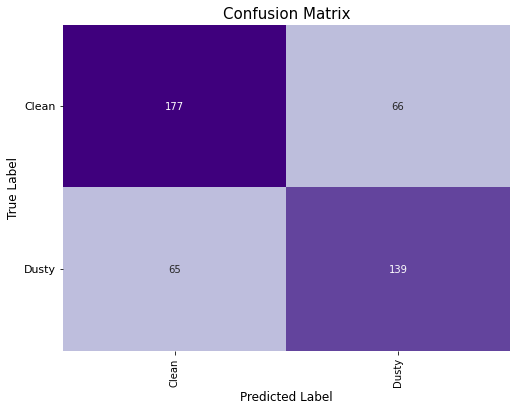

In [79]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm(tensor_pred, tensor_test), annot=True, vmin=0, fmt='g', cmap='Purples', cbar=False)
plt.xticks([0.5, 1.5], class_names, rotation=90, fontsize=10)
plt.yticks([0.5, 1.5], class_names, rotation=0, fontsize=11)
plt.title("Confusion Matrix", fontsize=15)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.show()